# ECON 621 Final Project
## Global temperature changes and prevalence of child stunting
#### Jill Adona and Shiv Garge

##### Introduction

Undernourishment in children at high rates can result in a devastating loss of a nation's human and economic potential, however, while most multi-sectoral factors affecting undernutrition have been studied extensively, there is relatively little evidence documenting the linkages between environmental conditions and child stunting.

The determinants of child undernutrition are divided into three groups: immediate, underlying, and basic, and were first described in the United Nations Children's Fund (UNICEF) conceptual framework of child undernutrition in 1990. A child can become undernourished, at the immediate level, due to poor nutritional intake, illness, or both. The underlying causes are related to food security, maternal and childcare practices, water and sanitation, and personal hygiene. Immediate and underlying causes interact and are themselves supported by the basic determinants: the availability, allocation, and use of resources in society. In addition, environmental constraints such as natural disasters, recurrent droughts and floods only exacerbate the situation. 

Environmental conditions, such as rising temperatures and extreme rainfall, can affect human health. Related literature commonly focus on health outcomes (mortality, birthweight) as well as economic, identifying agriculture as the mechanism between environment and child nutrition. Headey et al. (2001) using a global data set from 1960 onward concluded that (a) agricultural growth generally has had a large and significant effect on reducing stunting, and (b) increased food production is an important link between agricultural growth and nutrition when overall food production is low. There are, however, other mechanisms than agriculture. Extreme heat may also stunt child growth through increasing the risk of acute health problems in children, including infectious disease (because microbes tend to thrive in warm environments) or through direct, physiological effects on child health such as thermal stress-induced dehydration and heat exhaustion (Zivin and Shrader, 2016). The long-term effects of heat exposure may also be large enough to reverse decades of progress in reducing undernutrition. In Sub-Saharan Africa, Baker and Anttila-Hughes (2020) find that child weight declines with lifetime average temperatures exceeding 25 ◦C, and intensifies with age. Similarly in West Africa, Blom, Ortiz-Bobea and Hoddinott (2022) estimate that a 2 ◦C rise in temperature increases the prevalence of stunting by 7.4 percentage points. 

This paper estimates the effects of changes in the average annual temperature on child stunting rates at a global scale. We do not identify specific mechanisms through which temperature affects undernutrition and instead estimate probabilities of stunting levels, including annual temperature changes as a determinant.

##### Data

We begin by cleaning the datasets and extracting variables we will use in this project. 

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

Stunting has become the leading single measure of child malnutrition used worldwide. Stunting captures whether a child’s height-for-age is more than 2 standard deviations below the median of a reference population. Linear growth retardation and stunting are associated with the consequences of child malnutrition: delayed child development, reduced earnings in adulthood and increased risk of developing chronic diseases. 

We focus on children aged 0 to 5 years and use stunting rates from the UNICEF/WHO/The World Bank Group joint child malnutrition estimates (JME). National estimates per country from surveys on stunting, at different time periods (depends on years the country carries out the survey, so this varies across countries; not all countries conduct their health surveys annually), until before 2020. Since this variable is continuous, we will create a categorical (ordinal) outcome variable that sorts these rates into: very low stunting, low stunting, moderate stunting, high stunting, and very high stunting.

In [2]:
# Import dataset: Excel
df_jme = pd.read_excel('UNICEF_WHO_WB_Global_Expanded_Databases_Stunting_May_2022.xlsx', sheet_name='Trend', usecols=['ISO3Code', 'CountryName', 'UNRegion', 'WB_Latest', 'CMRS_year', 'National_r'], header=8)

# Generate ID variables: ISO country code and Year
df_jme['ISO'] = df_jme['ISO3Code'].astype("string")
df_jme['Year'] = df_jme['CMRS_year']

df_jme.head()

,ISO3Code,CountryName,UNRegion,WB_Latest,CMRS_year,National_r,ISO,Year
0,AFG,Afghanistan,Asia,Low Income,1997,53.20000,AFG,1997
1,AFG,Afghanistan,Asia,Low Income,2004,59.30000,AFG,2004
2,AFG,Afghanistan,Asia,Low Income,2013,40.41354,AFG,2013
3,AFG,Afghanistan,Asia,Low Income,2018,38.19278,AFG,2018
4,ALB,Albania,Europe,Upper Middle Income,1997,20.40000,ALB,1997


In [3]:
df_jme = df_jme.drop_duplicates(subset=['ISO', 'Year'], keep='last')
df_jme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 974 entries, 0 to 999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ISO3Code     974 non-null    object 
 1   CountryName  974 non-null    object 
 2   UNRegion     974 non-null    object 
 3   WB_Latest    974 non-null    object 
 4   CMRS_year    974 non-null    int64  
 5   National_r   974 non-null    float64
 6   ISO          974 non-null    string 
 7   Year         974 non-null    int64  
dtypes: float64(1), int64(2), object(4), string(1)
memory usage: 68.5+ KB


array([[<AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'National_r'}>]], dtype=object)

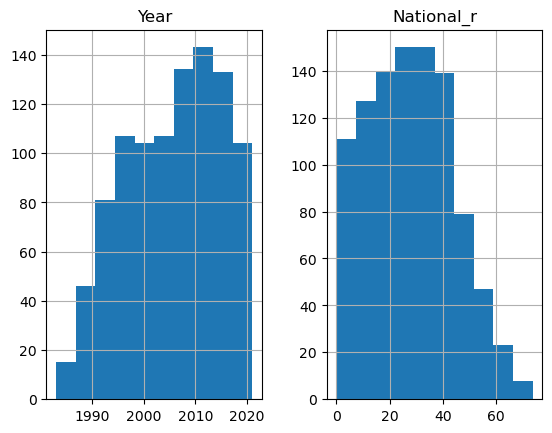

In [4]:
# FIGURE: distribution of data
df_jme.hist(column=["Year", "National_r"])

In [5]:
# Creating functions to speedup data filtering for data vizulisations. 

# Arguments for functions:
# df - target dataframe to pull data from
# region - Region from df ( must be in string aka 'in quotes' )
# year - int value (can use a list to itterate through year to get time series)

# This function filters data accoring to region in a specific year
def region_data_finder(df, region, year):
    df_region = df[ (df['UNRegion'] == region) & (df['Year'] == year)]
    return df_region

# This function gets discriptive statistics for a region in a specific year
def region_data_stats(df, region, year):
    df_region = df[ (df['UNRegion'] == region) & (df['Year'] == year)]
    stats = df_region['National_r'].describe()
    return stats

# This function gets the mean stunting rate for a specific year from a specific region
def region_data_mean(df, region, year):
    df_region = df[ (df['UNRegion'] == region) & (df['Year'] == year)]
    stats = df_region['National_r'].mean()
    return stats

#This returns a table of all countries' stunting rates for a specific year
def all_country_data(df, year):
    df_countries = df[(df['Year'] == year)]
    return df_countries

#This returns all data for a specific country
def country_data(df, country):
    df_country = df[(df['Country'] == country)]
    return df_country

In [6]:
print("In 2020, the average stunting rate among countries in Asia was ", region_data_mean(df_jme, 'Asia', 2020))
print("The summary statistics for the same region in 2020 are ", region_data_stats(df_jme, 'Asia', 2020))

In 2020, the average stunting rate among countries in Asia was  24.997298999999998
The summary statistics for the same region in 2020 are  count     3.000000
mean     24.997299
std      19.559272
min       8.703397
25%      14.151699
50%      19.600000
75%      33.144250
max      46.688500
Name: National_r, dtype: float64


The most recent available data for each of the countries from the JME show that half of the countries in the sample have a prevalence of under-five stunting is higher at 25.87 percent, that is, one in four children under age five are stunted.

<AxesSubplot:title={'center':'UNICEF/WHO/The World Bank Group joint child malnutrition estimates (JME), 2020'}, ylabel='CountryName'>

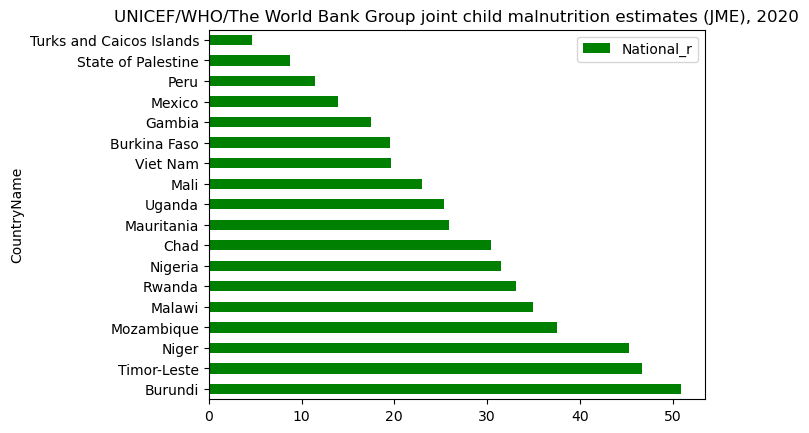

In [7]:
# FIGURE: select countries' recent data: 2020
df_world_2020 = all_country_data(df_jme, 2020)
df_world_2020 = df_world_2020.drop_duplicates(subset=['CountryName', 'Year'], keep='last')

df_world_2020 = df_world_2020.sort_values(['National_r'], ascending = [False])

df_world_2020.plot.barh(x='CountryName', y='National_r', 
            title='UNICEF/WHO/The World Bank Group joint child malnutrition estimates (JME), 2020', color='green')
#df_world_2020

The International Monetary Fund (IMF) maintains the Annual Surface Temperature Change database, which contains changes in the mean surface temperature, in Degree Celsius, for the years 1961-2021 by country. The value is temperature change with respect to a baseline climatology, corresponding to the period 1951-1980. The statistics are directly from the Food and Agriculture Organization of the United Nations (FAO).

In [8]:
# Import raw dataset: CSV
df_temp = pd.read_csv('Annual_Surface_Temperature_Change.csv')

# Include columns containing delta temp
df_temp = df_temp.drop(['ObjectId', 'ISO2', 'Indicator', 'Unit', 'Source', 'CTS_Code', 'CTS_Name', 'CTS_Full_Descriptor'], axis=1)

# Set 3-digit ISO country code as the index
df_temp = df_temp.set_index(['ISO3', 'Country'])

# Reshape data from wide to long
df_temp = df_temp.melt(ignore_index=False)

# Clean up variables
df_temp = df_temp.rename(columns={'variable': 'FYear', 'value': 'delta_temp'})
df_temp['FYear'] = df_temp.FYear.str.extract(r'(\d+[.\d]*)')
df_temp['Year'] = df_temp['FYear'].astype("int64")

# Add Year to index
df_temp = df_temp.set_index(['Year'], append=True)

df_temp.head()

,,,FYear,delta_temp
ISO3,Country,Year,,
AFG,"Afghanistan, Islamic Rep. of",1961,1961,-0.105
ALB,Albania,1961,1961,0.627
DZA,Algeria,1961,1961,0.162
ASM,American Samoa,1961,1961,0.066
AND,"Andorra, Principality of",1961,1961,0.744


In [9]:
df_temp.reset_index(inplace=True)
df_temp['ISO'] = df_temp['ISO3'].astype("string")
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13847 entries, 0 to 13846
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ISO3        13847 non-null  object 
 1   Country     13847 non-null  object 
 2   Year        13847 non-null  int64  
 3   FYear       13847 non-null  object 
 4   delta_temp  12333 non-null  float64
 5   ISO         13847 non-null  string 
dtypes: float64(1), int64(1), object(3), string(1)
memory usage: 649.2+ KB


In [10]:
# Merge datasets: JME and Temperature
df_jme_temp = pd.merge(df_jme, df_temp,  how='outer', left_on=['ISO','Year'], right_on = ['ISO','Year'])
df_jme_temp

,ISO3Code,CountryName,UNRegion,WB_Latest,CMRS_year,National_r,ISO,Year,ISO3,Country,FYear,delta_temp
0,AFG,Afghanistan,Asia,Low Income,1997.0,53.20000,AFG,1997,AFG,"Afghanistan, Islamic Rep. of",1997,0.592
1,AFG,Afghanistan,Asia,Low Income,2004.0,59.30000,AFG,2004,AFG,"Afghanistan, Islamic Rep. of",2004,1.427
2,AFG,Afghanistan,Asia,Low Income,2013.0,40.41354,AFG,2013,AFG,"Afghanistan, Islamic Rep. of",2013,1.308
3,AFG,Afghanistan,Asia,Low Income,2018.0,38.19278,AFG,2018,AFG,"Afghanistan, Islamic Rep. of",2018,1.580
4,ALB,Albania,Europe,Upper Middle Income,1997.0,20.40000,ALB,1997,ALB,Albania,1997,0.113
...,...,...,...,...,...,...,...,...,...,...,...,...
13848,NaN,NaN,NaN,NaN,NaN,NaN,ESH,2021,ESH,Western Sahara,2021,1.557
13849,NaN,NaN,NaN,NaN,NaN,NaN,WLD,2021,WLD,World,2021,1.442
13850,NaN,NaN,NaN,NaN,NaN,NaN,YEM,2021,YEM,"Yemen, Rep. of",2021,NaN
13851,NaN,NaN,NaN,NaN,NaN,NaN,ZMB,2021,ZMB,Zambia,2021,1.002


In [11]:
df_jme_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13853 entries, 0 to 13852
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ISO3Code     974 non-null    object 
 1   CountryName  974 non-null    object 
 2   UNRegion     974 non-null    object 
 3   WB_Latest    974 non-null    object 
 4   CMRS_year    974 non-null    float64
 5   National_r   974 non-null    float64
 6   ISO          13853 non-null  string 
 7   Year         13853 non-null  int64  
 8   ISO3         13847 non-null  object 
 9   Country      13847 non-null  object 
 10  FYear        13847 non-null  object 
 11  delta_temp   12333 non-null  float64
dtypes: float64(3), int64(1), object(7), string(1)
memory usage: 1.4+ MB


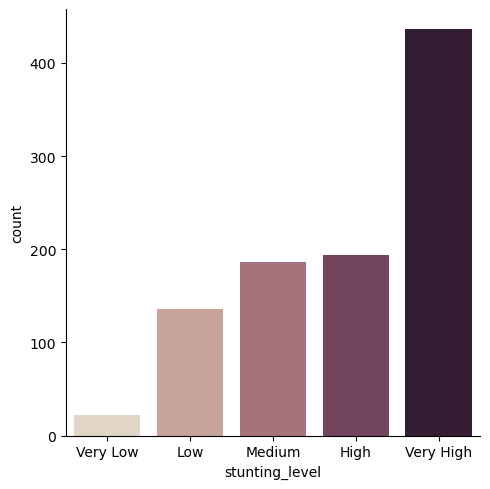

In [12]:
# Generate outcome: categorical variable
conditions = [
    (df_jme_temp['National_r'] < 2.5),
    (df_jme_temp['National_r'] >= 2.5) & (df_jme_temp['National_r'] < 10),
    (df_jme_temp['National_r'] >= 10) & (df_jme_temp['National_r'] < 20),
    (df_jme_temp['National_r'] >= 20) & (df_jme_temp['National_r'] < 30),
    (df_jme_temp['National_r'] >= 30)]
outcomes = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
df_jme_temp['stunting_prevalence'] = np.select(conditions, outcomes)

cat_type = CategoricalDtype(categories=['Very Low', 'Low', 'Medium', 'High', 'Very High'], ordered=True)
df_jme_temp["stunting_level"] = df_jme_temp["stunting_prevalence"].astype(cat_type)

sns.catplot(data=df_jme_temp, x="stunting_level", kind="count", palette="ch:.25")

In [13]:
# Check for missing values:
df_jme_temp.isna().sum()
# Drop these missing values: these are extra observations from the temperature dataset since it goes back more years than JME
df_jme_temp.dropna()

,ISO3Code,CountryName,UNRegion,WB_Latest,CMRS_year,National_r,ISO,Year,ISO3,Country,FYear,delta_temp,stunting_prevalence,stunting_level
0,AFG,Afghanistan,Asia,Low Income,1997.0,53.20000,AFG,1997,AFG,"Afghanistan, Islamic Rep. of",1997,0.592,Very High,Very High
1,AFG,Afghanistan,Asia,Low Income,2004.0,59.30000,AFG,2004,AFG,"Afghanistan, Islamic Rep. of",2004,1.427,Very High,Very High
2,AFG,Afghanistan,Asia,Low Income,2013.0,40.41354,AFG,2013,AFG,"Afghanistan, Islamic Rep. of",2013,1.308,Very High,Very High
3,AFG,Afghanistan,Asia,Low Income,2018.0,38.19278,AFG,2018,AFG,"Afghanistan, Islamic Rep. of",2018,1.580,Very High,Very High
4,ALB,Albania,Europe,Upper Middle Income,1997.0,20.40000,ALB,1997,ALB,Albania,1997,0.113,High,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,ZWE,Zimbabwe,Africa,Lower Middle Income,2009.0,35.07278,ZWE,2009,ZWE,Zimbabwe,2009,-0.336,Very High,Very High
970,ZWE,Zimbabwe,Africa,Lower Middle Income,2010.0,32.20514,ZWE,2010,ZWE,Zimbabwe,2010,0.918,Very High,Very High
971,ZWE,Zimbabwe,Africa,Lower Middle Income,2014.0,27.60668,ZWE,2014,ZWE,Zimbabwe,2014,-0.008,High,High
972,ZWE,Zimbabwe,Africa,Lower Middle Income,2015.0,27.07350,ZWE,2015,ZWE,Zimbabwe,2015,0.808,High,High


##### Summary statistics

We can visualize annual temperature changes over time in a heatmap below.

[Text(0.5, 23.52222222222222, 'Year'),
 Text(50.58159722222221, 0.5, 'Global mean: average annual temperature change')]

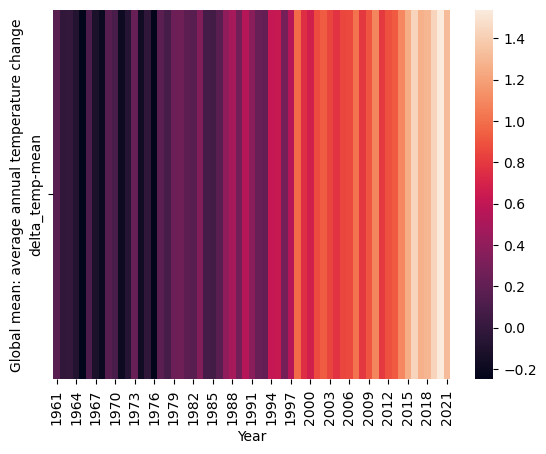

In [14]:
# FIGURE: HEATMAP - average annual temperature changes per year
dfm_temp_hm = df_jme_temp.groupby(['Year']).agg({'delta_temp': ['mean']}) 
hm1 = sns.heatmap(dfm_temp_hm.T)
hm1.set(xlabel="Year", ylabel="Global mean: average annual temperature change")

In [15]:
# Table: Stunting rates and average annual change in temperature (degree Celsius), mean per region by year
df_jme_temp.groupby(['Year', 'UNRegion']).agg({'National_r': ['min', 'max', 'mean', 'std', 'count'], 'delta_temp': ['mean', 'std', 'count']})

National_r                       \
                                            min       max       mean   
Year UNRegion                                                          
1983 Oceania                          46.000000  46.00000  46.000000   
1985 Africa                           26.800000  43.80000  32.633333   
     Oceania                          34.400000  34.40000  34.400000   
1986 Africa                           19.642260  32.00000  26.047420   
     Asia                             62.500000  70.90000  66.700000   
...                                         ...       ...        ...   
2019 Oceania                           2.176667   7.29319   5.048646   
2020 Africa                           17.477570  50.91323  31.244929   
     Asia                              8.703397  46.68850  24.997299   
     Latin America and the Caribbean   4.610320  13.92910   9.978980   
2021 Africa                           17.358670  44.44987  30.191003   

                                                      delta_temp            \
                                            std count       mean       std   
Year UNRegion                                                                
1983 Oceania                                NaN     1   0.325000       NaN   
1985 Africa                            9.673848     3   0.235333  0.318151   
     Oceania                                NaN     1   0.120000       NaN   
1986 Africa                            6.191289     3   0.186500  0.389616   
     Asia                              5.939697     2  -0.123000  0.212132   
...                                         ...   ...        ...       ...   
2019 Oceania                           2.615331     3   0.995667  0.152775   
2020 Africa                            9.999774    12   1.265900  0.394423   
     Asia                             19.559272     3   1.635000  0.113080   
     Latin America and the Caribbean   4.818621     3   1.623000  0.024042   
2021 Africa                           10.405574     6   1.521667  0.388432   

                                            
                                     count  
Year UNRegion                               
1983 Oceania                             1  
1985 Africa                              3  
     Oceania                             1  
1986 Africa                              2  
     Asia                                2  
...                                    ...  
2019 Oceania                             3  
2020 Africa                             10  
     Asia                                3  
     Latin America and the Caribbean     2  
2021 Africa                              6  

[160 rows x 8 columns]

UNRegion
Africa                             AxesSubplot(0.125,0.11;0.775x0.77)
Asia                               AxesSubplot(0.125,0.11;0.775x0.77)
Europe                             AxesSubplot(0.125,0.11;0.775x0.77)
Latin America and the Caribbean    AxesSubplot(0.125,0.11;0.775x0.77)
Northern America                   AxesSubplot(0.125,0.11;0.775x0.77)
Oceania                            AxesSubplot(0.125,0.11;0.775x0.77)
Name: mean, dtype: object

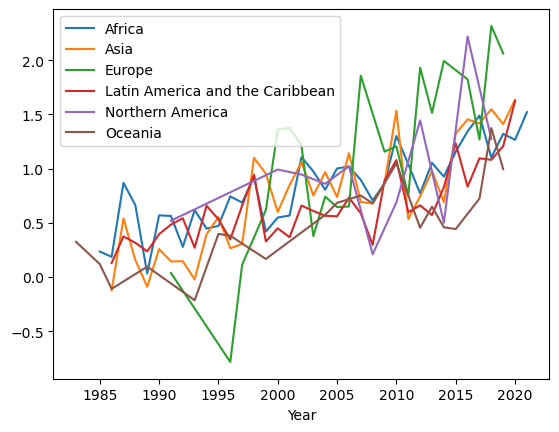

In [16]:
# FIGURE: Average annual change in temperature - mean across regions, over time
dfm_temp_plot = df_jme_temp.groupby(['Year', 'UNRegion'])['delta_temp'].agg(['mean'])
dfm_temp_plot.reset_index(inplace=True)

dfm_temp_plot.set_index('Year', inplace=True)
dfm_temp_plot.groupby('UNRegion')['mean'].plot(legend=True)

The figure above illustrates increasing temperatures across regions, since 1983. Climate change is expected to have a direct effect on agricultural productivity, livestock, and fisheries production by affecting cropping calendars, yield quality, and yield levels (OECD 2017). Extreme weather may have an indirect effect by leading to the proliferation of pests on agricultural land and driving the incidence of diseases. Rising sea levels could also negatively affect the land available for crops, increase the risk of flooding and storm damage, and lead to the salinization of coastal croplands.

UNRegion
Africa                             AxesSubplot(0.125,0.11;0.775x0.77)
Asia                               AxesSubplot(0.125,0.11;0.775x0.77)
Europe                             AxesSubplot(0.125,0.11;0.775x0.77)
Latin America and the Caribbean    AxesSubplot(0.125,0.11;0.775x0.77)
Northern America                   AxesSubplot(0.125,0.11;0.775x0.77)
Oceania                            AxesSubplot(0.125,0.11;0.775x0.77)
Name: mean, dtype: object

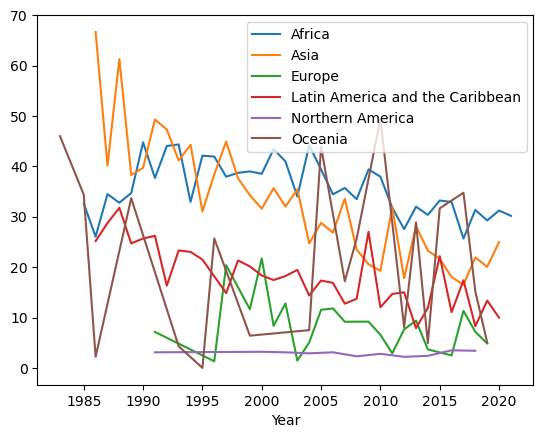

In [17]:
# FIGURE: Stunting rate - mean across regions, over time
dfm_jme_plot = df_jme_temp.groupby(['Year', 'UNRegion'])['National_r'].agg(['mean'])
dfm_jme_plot.reset_index(inplace=True)

dfm_jme_plot.set_index('Year', inplace=True)
dfm_jme_plot.groupby('UNRegion')['mean'].plot(legend=True)

Stunting has declined steadily since the early 1980s, and from 33.1 percent in 2000 to 22.0 percent in 2020. Globally, 149.2 million children under 5 suffered from stunting in 2020. Three geographic regions account for 90 percent of this figure: 38 percent of children classified as stunted live in Sub-Saharan Africa, 36 percent in South Asia, and 14 percent in East Asia and the Pacific. The prevalence of stunting has declined over time in most regions except in Sub-Saharan Africa, where it increased from 50.4 million children in 2000 to 57.3 million in 2020.

WB_Latest
High Income            AxesSubplot(0.125,0.11;0.775x0.77)
Low Income             AxesSubplot(0.125,0.11;0.775x0.77)
Lower Middle Income    AxesSubplot(0.125,0.11;0.775x0.77)
Not Classified         AxesSubplot(0.125,0.11;0.775x0.77)
Upper Middle Income    AxesSubplot(0.125,0.11;0.775x0.77)
Name: mean, dtype: object

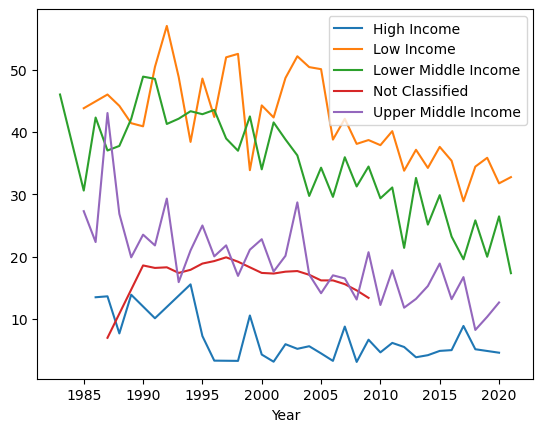

In [18]:
# FIGURE: Stunting rate - mean across WB income regions, over time
dfm_jme_plot = df_jme_temp.groupby(['Year', 'WB_Latest'])['National_r'].agg(['mean'])
dfm_jme_plot.reset_index(inplace=True)

dfm_jme_plot.set_index('Year', inplace=True)
dfm_jme_plot.groupby('WB_Latest')['mean'].plot(legend=True)

An interesting relationship is that between income and stunting. Globally, average stunting rates tend to decline as countries get richer, but the relationship is weak, suggesting that other factors play in the evolution of stunting over time. The previous figure shows that high-income countries have generally had low rates of stunting, whereas low- and lower-middle-income countries have experienced high rates of child stunting since 1983, and still high rates in 2020.

To add independent variables to our merged dataset containing average annual change in temperature and stunting prevalence over time, we use WBGAPI, a package to access World Bank databases. 

In [19]:
import wbgapi as wb

# Create a function that will call on WBGAPI to retrieve dataframes:
def wbg_df(indicator):
    # Retrieve data
    df = wb.data.DataFrame(indicator, labels=True).reset_index()
    # Set 3-digit ISO country code as the index
    df = df.set_index(['economy'])
    # Subset the data to only include columns containing value
    df = df.loc[:, 'YR1960':'YR2021']
    # Reshape data from wide to long
    df = df.melt(ignore_index=False)
    df = df.rename(columns={'variable': 'Year'})
    df['Year'] = df.Year.str.extract(r'(\d+[.\d]*)')
    # Add Year to index
    df = df.set_index(['Year'], append=True)
    return df

In [20]:
#NY.GDP.PCAP.PP.KD	GDP per capita, PPP (constant 2017 international $)
wb_gdppc = wbg_df('NY.GDP.PCAP.PP.KD')
wb_gdppc = wb_gdppc.rename(columns={'value': 'gdppc'})

#SI.POV.NAHC	Poverty headcount ratio at national poverty lines (% of population)
wb_pov = wbg_df('SI.POV.NAHC')
wb_pov = wb_pov.rename(columns={'value': 'pov'})

#AG.PRD.FOOD.XD	Food production index (2014-2016 = 100)
wb_agprd = wbg_df('AG.PRD.FOOD.XD')
wb_agprd = wb_agprd.rename(columns={'value': 'agprd'})

#SH.STA.BASS.ZS	People using at least basic sanitation services (% of population)
wb_wash = wbg_df('SH.STA.BASS.ZS')
wb_wash = wb_wash.rename(columns={'value': 'wash'})

#SE.ADT.LITR.ZS	Literacy rate, adult total (% of people ages 15 and above)
wb_litr = wbg_df('SE.ADT.LITR.ZS')
wb_litr = wb_litr.rename(columns={'value': 'litr'})

In [21]:
# Combine all WB dataframes into one
df_wb = pd.concat([wb_gdppc, wb_pov, wb_agprd, wb_wash, wb_litr], axis=1)
df_wb.reset_index(inplace=True)

In [22]:
# Clean up df_wb:
# Keep only years 1983 onwards since this is when our JME obs start anyway
df_wb['yr'] = pd.to_numeric(df_wb['Year'],errors='coerce')
df_wb = df_wb[df_wb['yr'] >= 1983]

# Drop rows which are aggregates:
aggregates = ['AFE', 'AFW', 'ARB', 'CEB', 'CSS', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU', 'EUU', 'FCS', 'HIC', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX', 'INX', 'LAC', 'LCN', 'LDC', 'LIC', 'LMC', 'LMY', 'LTE', 'MEA', 'MIC', 'MNA', 'NAC', 'OED', 'OSS', 'PRE', 'PSS', 'PST', 'SAS', 'SSA', 'SSF', 'SST', 'TEA', 'TEC', 'TLA', 'TMN', 'TSA', 'TSS', 'UMC', 'WLD']
df_wb = df_wb[~df_wb['economy'].isin(aggregates)]

# Drop any duplicates, if any
df_wb = df_wb.drop_duplicates(keep='first')
df_wb

,economy,Year,gdppc,pov,agprd,wash,litr,yr
6118,ZWE,1983,NaN,NaN,79.99,NaN,NaN,1983
6119,ZMB,1983,NaN,NaN,26.93,NaN,NaN,1983
6120,YEM,1983,NaN,NaN,30.69,NaN,NaN,1983
6121,PSE,1983,NaN,NaN,NaN,NaN,NaN,1983
6122,VIR,1983,NaN,NaN,129.43,NaN,NaN,1983
...,...,...,...,...,...,...,...,...
16438,AND,2021,NaN,NaN,NaN,NaN,NaN,2021
16439,ASM,2021,NaN,NaN,NaN,NaN,NaN,2021
16440,DZA,2021,10957.159923,NaN,NaN,NaN,NaN,2021
16441,ALB,2021,14520.111035,NaN,NaN,NaN,NaN,2021


In [23]:
df_wb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8463 entries, 6118 to 16442
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   economy  8463 non-null   object 
 1   Year     8463 non-null   object 
 2   gdppc    5883 non-null   float64
 3   pov      1078 non-null   float64
 4   agprd    7354 non-null   float64
 5   wash     4382 non-null   float64
 6   litr     891 non-null    float64
 7   yr       8463 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 595.1+ KB


In [24]:
# Clean up WB df for merging
#df_wb = df_wb.drop(['yr'], axis=1)
df_wb['Year'] = df_wb['Year'].astype("int64")
df_wb['ISO'] = df_wb['economy'].astype("string")

In [25]:
# Merge our JME-temp dataset with the WBG dataset
df_jme_temp_wb = pd.merge(df_jme_temp, df_wb,  how='inner', left_on=['ISO','Year'], right_on = ['ISO','Year'])
df_jme_temp_wb

,ISO3Code,CountryName,UNRegion,WB_Latest,CMRS_year,National_r,ISO,Year,ISO3,Country,...,delta_temp,stunting_prevalence,stunting_level,economy,gdppc,pov,agprd,wash,litr,yr
0,AFG,Afghanistan,Asia,Low Income,1997.0,53.20000,AFG,1997,AFG,"Afghanistan, Islamic Rep. of",...,0.592,Very High,Very High,AFG,NaN,NaN,77.46,NaN,NaN,1997
1,AFG,Afghanistan,Asia,Low Income,2004.0,59.30000,AFG,2004,AFG,"Afghanistan, Islamic Rep. of",...,1.427,Very High,Very High,AFG,1200.278013,NaN,75.77,26.067695,NaN,2004
2,AFG,Afghanistan,Asia,Low Income,2013.0,40.41354,AFG,2013,AFG,"Afghanistan, Islamic Rep. of",...,1.308,Very High,Very High,AFG,2116.465258,NaN,94.29,39.506018,NaN,2013
3,AFG,Afghanistan,Asia,Low Income,2018.0,38.19278,AFG,2018,AFG,"Afghanistan, Islamic Rep. of",...,1.580,Very High,Very High,AFG,2033.804389,NaN,97.45,47.390662,NaN,2018
4,ALB,Albania,Europe,Upper Middle Income,1997.0,20.40000,ALB,1997,ALB,Albania,...,0.113,High,High,ALB,4400.318994,NaN,58.80,NaN,NaN,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8113,NaN,NaN,NaN,NaN,NaN,NaN,VNM,2021,VNM,Vietnam,...,1.193,0,NaN,VNM,10516.222812,NaN,NaN,NaN,NaN,2021
8114,NaN,NaN,NaN,NaN,NaN,NaN,PSE,2021,PSE,West Bank and Gaza,...,1.887,0,NaN,PSE,5643.072243,NaN,NaN,NaN,NaN,2021
8115,NaN,NaN,NaN,NaN,NaN,NaN,YEM,2021,YEM,"Yemen, Rep. of",...,NaN,0,NaN,YEM,NaN,NaN,NaN,NaN,NaN,2021
8116,NaN,NaN,NaN,NaN,NaN,NaN,ZMB,2021,ZMB,Zambia,...,1.002,0,NaN,ZMB,3298.626768,NaN,NaN,NaN,NaN,2021


In [26]:
# Check for missing values:
df_jme_temp_wb.isna().sum()

ISO3Code               7144
CountryName            7144
UNRegion               7144
WB_Latest              7144
CMRS_year              7144
National_r             7144
ISO                       0
Year                      0
ISO3                      6
Country                   6
FYear                     6
delta_temp              632
stunting_prevalence       0
stunting_level         7144
economy                   0
gdppc                  2339
pov                    7046
agprd                   868
wash                   3879
litr                   7232
yr                        0
dtype: int64

In [27]:
# Drop these missing values: these are extra observations from the WB dataset since it goes back more years than JME-temp
df_jme_temp_wb = df_jme_temp_wb.dropna()

In the above blocks, we attempted to merge the dataframe generated from WBGAPI to our JME-Temperature dataset. However, we encounter a missing data problem: we only observe full data for our target independent variables for 63 observations. It is possible that for the years there are estimates for malnutrition, there are missing values for our other independent variables. Unfortunately, we will have to proceed without these controls to estimate the linkages between weather and child undernutrition, which is the main focus of this paper.

##### Ordinal logit regression

We use ordinal regression to model the relationship between child stunting levels and changes in average annual temperature in countries. Ordinal (ordered) logistic regression is a variant of regression models that normally gets utilized when the data has an ordinal outcome variable. The levels of stunting are categorical, but in order: Very Low, Low, Medium, High, and Very High.

In [28]:
# Remove observations that have stunting_level and/or delta_temp missing from the JME-temperature dataset:
df = df_jme_temp.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 928 entries, 0 to 973
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ISO3Code             928 non-null    object  
 1   CountryName          928 non-null    object  
 2   UNRegion             928 non-null    object  
 3   WB_Latest            928 non-null    object  
 4   CMRS_year            928 non-null    float64 
 5   National_r           928 non-null    float64 
 6   ISO                  928 non-null    string  
 7   Year                 928 non-null    int64   
 8   ISO3                 928 non-null    object  
 9   Country              928 non-null    object  
 10  FYear                928 non-null    object  
 11  delta_temp           928 non-null    float64 
 12  stunting_prevalence  928 non-null    object  
 13  stunting_level       928 non-null    category
dtypes: category(1), float64(3), int64(1), object(8), string(1)
memory usage: 1

We simply pool the data over the years. The figure below plots average annual temperature changes and stunting prevalence.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 41.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


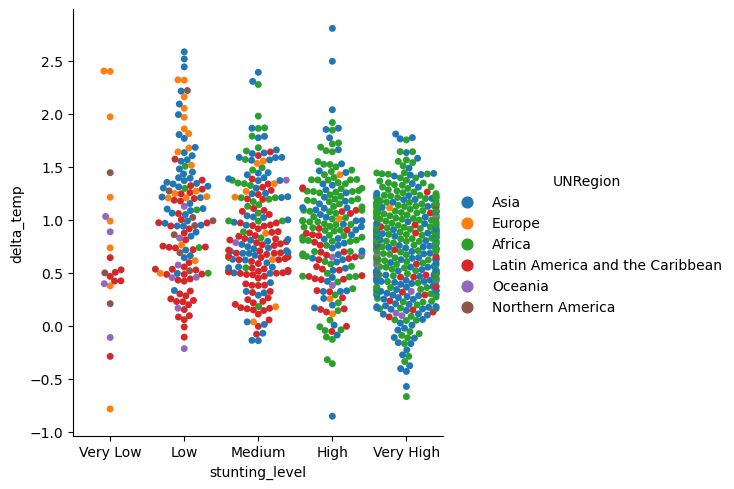

In [29]:
sns.catplot(data=df, x="stunting_level", y="delta_temp", hue="UNRegion", kind="swarm")

In [30]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

# First estimate an ordered probit model:
mod_prob = OrderedModel(df['stunting_level'],
                        df[['delta_temp']],
                        distr='probit')
 
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

Optimization terminated successfully.
         Current function value: 1.358218
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         stunting_level   Log-Likelihood:                -1260.4
Model:                   OrderedModel   AIC:                             2531.
Method:            Maximum Likelihood   BIC:                             2555.
Date:                Tue, 20 Dec 2022                                         
Time:                        22:26:58                                         
No. Observations:                 928                                         
Df Residuals:                     923                                         
Df Model:                           5                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
delta_temp        -0.3694      0.069     -5.334      0.000      -0.505      -0.234
Very Low/Low      -2.3195      0.110    -21.124      0.000      -2.535      -2.104
Low/Medium         0.0110      0.085      0.130      0.896      -0.155       0.177
Medium/High       -0.4441      0.067     -6.657      0.000      -0.575      -0.313
High/Very High    -0.6258      0.066     -9.496      0.000      -0.755      -0.497
==================================================================================
"""

In [31]:
# Estimate the ordered logit model
mod_log = OrderedModel(df['stunting_level'],
                        df[['delta_temp']],
                        distr='logit')
 
res_log = mod_log.fit(method='bfgs')
res_log.summary()

Optimization terminated successfully.
         Current function value: 1.355592
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         stunting_level   Log-Likelihood:                -1258.0
Model:                   OrderedModel   AIC:                             2526.
Method:            Maximum Likelihood   BIC:                             2550.
Date:                Tue, 20 Dec 2022                                         
Time:                        22:26:58                                         
No. Observations:                 928                                         
Df Residuals:                     923                                         
Df Model:                           5                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
delta_temp        -0.6813      0.119     -5.749      0.000      -0.914      -0.449
Very Low/Low      -4.3593      0.246    -17.721      0.000      -4.841      -3.877
Low/Medium         0.7472      0.096      7.758      0.000       0.558       0.936
Medium/High        0.0908      0.069      1.318      0.187      -0.044       0.226
High/Very High    -0.1461      0.066     -2.198      0.028      -0.276      -0.016
==================================================================================
"""

The table of results defined the thresholds between Very Low and Low, Low and Medium, Medium and High, and then High and Very High rates of stunting. The coefficient of delta_temp, beta, indicates the regression coefficient for the average annual temperature change and we have four thresholds between outcomes (highly statistically significant (P=0.000)).

For reference, we can run the ordered logit model for the full model, with the caveat that we only have 63 observations in this dataframe.

In [32]:
# Estimate the ordered logit model for the full model
mod_log_full = OrderedModel(df_jme_temp_wb['stunting_level'],
                        df_jme_temp_wb[['delta_temp', 'gdppc', 'pov', 'agprd', 'wash', 'litr']],
                        distr='logit')
 
res_log_full = mod_log_full.fit(method='bfgs')
res_log_full.summary()

Optimization terminated successfully.
         Current function value: 0.927287
         Iterations: 39
         Function evaluations: 50
         Gradient evaluations: 50


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         stunting_level   Log-Likelihood:                -53.783
Model:                   OrderedModel   AIC:                             127.6
Method:            Maximum Likelihood   BIC:                             148.2
Date:                Tue, 20 Dec 2022                                         
Time:                        22:26:59                                         
No. Observations:                  58                                         
Df Residuals:                      48                                         
Df Model:                          10                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
delta_temp        -0.5225      0.684     -0.764      0.445      -1.862       0.817
gdppc             -0.0002   7.49e-05     -2.378      0.017      -0.000   -3.13e-05
pov               -0.0071      0.026     -0.277      0.782      -0.057       0.043
agprd              0.0017      0.018      0.093      0.926      -0.034       0.037
wash              -0.0410      0.020     -2.019      0.043      -0.081      -0.001
litr              -0.0085      0.023     -0.379      0.705      -0.053       0.036
Very Low/Low     -11.3750      3.270     -3.479      0.001     -17.783      -4.967
Low/Medium         0.9055      0.435      2.083      0.037       0.054       1.757
Medium/High        1.1584      0.232      4.997      0.000       0.704       1.613
High/Very High     0.6735      0.253      2.658      0.008       0.177       1.170
==================================================================================
"""

We get the same sign for delta_temp, however, interestingly, after adding our other independent variables, this variable loses its statistical significance (P=0.565). We instead find GDP per capita (gdppc) and the percentage of the population using at least basic sanitation services (wash) as statistically significant. Poverty headcount, agricultural productivity proxied by the food production index, and adult literacy rate are not statistically significant.

We transform the logit function into predicted probabilities to further make sense out of the results.

In [33]:
predicted = res_log.model.predict(res_log.params, exog=df[['delta_temp']])
predicted

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\miscmodels\ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


array([[0.01878078, 0.11770123, 0.18437946, 0.20766642, 0.4714721 ],
       [0.03270087, 0.18553674, 0.23664541, 0.20954524, 0.33557174],
       [0.03023139, 0.17449092, 0.2301423 , 0.21125387, 0.35388152],
       ...,
       [0.01255849, 0.08248259, 0.1438854 , 0.1879705 , 0.57310302],
       [0.02169354, 0.13307643, 0.1989648 , 0.21124286, 0.43502237],
       [0.02367067, 0.14313696, 0.20758521, 0.21237854, 0.41322862]])

Similarly, we get the predictions for the full model.

In [34]:
predicted_full = res_log_full.model.predict(res_log_full.params, exog= df_jme_temp_wb[['delta_temp', 'gdppc', 'pov', 'agprd', 'wash', 'litr']])
predicted_full

array([[1.53498578e-02, 1.40689479e-01, 6.61069961e-01, 1.52359104e-01,
        3.05315975e-02],
       [1.20438375e-04, 1.30611063e-03, 3.19425134e-02, 1.63641223e-01,
        8.02989715e-01],
       [1.87552251e-04, 2.03232048e-03, 4.87986184e-02, 2.25439531e-01,
        7.23541978e-01],
       [1.09297328e-01, 4.83428105e-01, 3.79625522e-01, 2.36640540e-02,
        3.98499126e-03],
       [8.14559137e-04, 8.76150691e-03, 1.79813069e-01, 4.34741324e-01,
        3.75869541e-01],
       [4.44999914e-03, 4.58945438e-02, 5.11259093e-01, 3.39431064e-01,
        9.89652998e-02],
       [1.77264454e-04, 1.92107564e-03, 4.62564851e-02, 2.16960058e-01,
        7.34685116e-01],
       [1.81078850e-04, 1.96232493e-03, 4.72007621e-02, 2.20142031e-01,
        7.30513804e-01],
       [7.56059080e-03, 7.53049951e-02, 6.02997199e-01, 2.53594278e-01,
        6.05429366e-02],
       [1.12307833e-02, 1.07487920e-01, 6.46276186e-01, 1.93572178e-01,
        4.14329326e-02],
       [6.26496640e-04, 6.7536

In [35]:
pred_choice = predicted.argmax(1)
print('Fraction of correct choice predictions')
print((np.asarray(df['stunting_level'].values.codes) == pred_choice).mean())

pred_choice_full = predicted_full.argmax(1)
print('Fraction of correct choice predictions in the full model')
print((np.asarray(df_jme_temp_wb['stunting_level'].values.codes) == pred_choice_full).mean())

Fraction of correct choice predictions
0.4396551724137931
Fraction of correct choice predictions in the full model
0.6206896551724138


##### Conclusion

In this notebook we used official data from different international organizations on child stunting and climate change. We processed, merged, and visualized the data before estimating an ordered logistic regression in an attempt to establish the linkages between weather and child undernutrition. From rich datasets, we were able to construct a dataframe of 953 country-year observations containing stunting levels and average annual change in temperature. In addition, we present a richer model adding GDP per capita, percentage of the population using at least basic sanitation services, poverty headcount, agricultural productivity proxied by the food production index, and adult literacy rate as independent variables.

We found puzzling results using only weather as an independent variable, however, using the full model on a smaller sample, we are able to say that we might not be finding direct effects of average annual temperature change on child stunting with the data we have. We found that GDP per capita and the percentage of the population using at least basic sanitation services are statistically significant in identifying levels of child stunting.

Earlier we cited studies that rigorously identify mechanisms between weather and child undernutrition. Further research is needed to identify these mechanisms to provide evidence on how climate change directly affects rates of child stunting worldwide.

##### References

* Baker, R. E., & Anttila-Hughes, J. (2020). Characterizing the contribution of high temperatures to child undernourishment in Sub-Saharan Africa. Scientific Reports, 10(1), Article 1. https://doi.org/10.1038/s41598-020-74942-9
* Blom, S., Ortiz-Bobea, A., & Hoddinott, J. (2022). Heat exposure and child nutrition: Evidence from West Africa. Journal of Environmental Economics and Management, 115, 102698. https://doi.org/10.1016/j.jeem.2022.102698
* Food and Agriculture Organization of the United Nations (FAO). (2022). FAOSTAT Climate Change, Climate Indicators, Temperature change. License: CC BY-NC-SA 3.0 IGO
* Headey, D., Heidkamp, R., Osendarp, S., Ruel, M., Scott, N., Black, R., Shekar, M., Bouis, H., Flory, A., Haddad, L., & Walker, N. (2020). Impacts of COVID-19 on childhood malnutrition and nutrition-related mortality. The Lancet, 396(10250), 519–521. https://doi.org/10.1016/S0140-6736(20)31647-0
* Mbuya, N. V. N., Demombynes, G., Piza, S. F. A., & Adona, A. J. V. (2021). Undernutrition in the Philippines: Scale, Scope, and Opportunities for Nutrition Policy and Programming. The World Bank. https://doi.org/10.1596/978-1-4648-1701-4
* UNICEF (United Nations Children’s Fund), WhO (World health Organization), and World Bank Group. (2020). Levels and Trends in Child Malnutrition: UNICEF/WHO/World Bank Group Joint Child Malnutrition Estimates. Geneva: WHO.
* UNICEF (United Nations Children’s Fund). (1990). Strategy for Improved Nutrition of Children and Women in Developing Countries. UNICEF Policy review. New York: UNICEF.
* Zivin, J. G., & Shrader, J. (2016). Temperature Extremes, Health, and Human Capital. Future of Children, 26(1), 31–50. https://eric.ed.gov/?id=EJ1101427
